In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
import sys

sys.path.append("../scripts")
from data import PatchesDataset, SmallPatchesDataset
from models import SmallAutoEncoder, AutoEncoder, DEC

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
ny_blocks = gpd.read_file("../data/new_york_blocks/new_york_blocks_mhi.geojson")

In [ ]:
# code to get the block id for each patch, takes a while to run
import warnings
warnings.filterwarnings('ignore')

patches_df = pd.concat([gpd.read_file("../data/output/ny_patches/" + f) for f in os.listdir("../data/output/ny_patches") if f.endswith(".geojson")])
patches_df = gpd.GeoDataFrame(patches_df)
patches_df = patches_df.sort_values("patche_filename")

block_id = []
for i, row in tqdm(patches_df.iterrows()):
    intersection_area = ny_blocks.geometry.intersection(row.geometry).area
    if intersection_area.sum() == 0:
        block_id.append(None)
    else:
        # get the block with the largest intersection
        block_id.append(ny_blocks.loc[intersection_area.idxmax()].name)
patches_df["block_id"] = block_id
patches_df[["entity_id", "patche_id", "patche_filename", "geometry", "block_id"]].to_file("../data/new_york_blocks/new_york_blocks_patches.geojson", index=False)

In [4]:
patches_df = gpd.read_file("../data/new_york_blocks/new_york_blocks_patches.geojson")
patches_df = patches_df.dropna()
filenames = patches_df.patche_filename.values
filenames = [os.path.join("../data/output/ny_patches", f) for f in filenames]

In [5]:
block_id_counts = patches_df.block_id.value_counts().to_frame().reset_index().rename(columns={"index": "block_id", "block_id": "count"})
block_id_counts.block_id = block_id_counts.block_id.astype(int)

In [6]:
ny_blocks["count"] = ny_blocks.index.map(lambda x: block_id_counts.loc[block_id_counts.block_id == x].iloc[0].values[1] if x in block_id_counts.block_id.values else 0)

<Axes: >

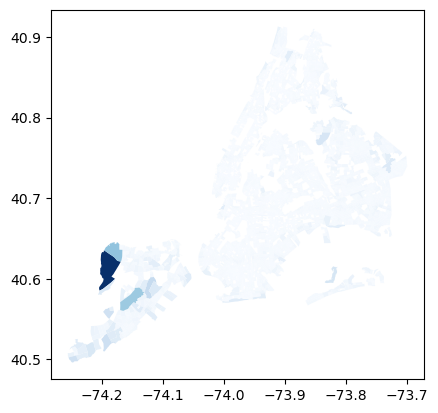

In [7]:
ny_blocks.plot(column="count", cmap = "Blues")

<Axes: >

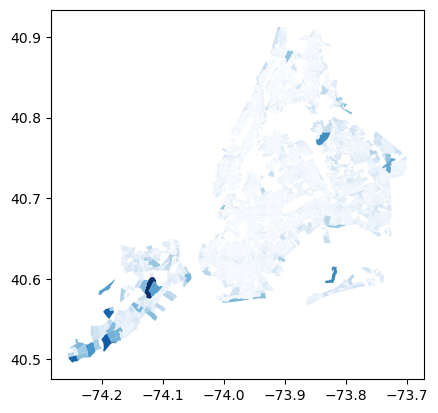

In [8]:
ny_blocks[ny_blocks["count"] < 200].plot(column="count", cmap = "Blues") 

<Axes: >

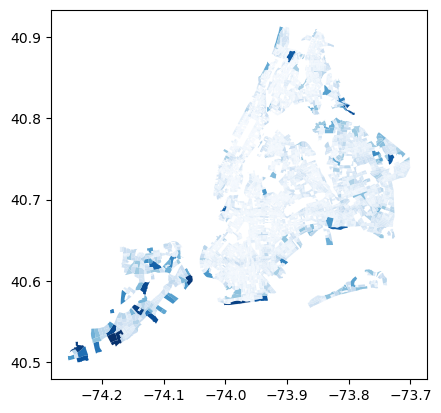

In [9]:
ny_blocks[ny_blocks["count"] < 100].plot(column="count", cmap = "Blues") 

<Axes: >

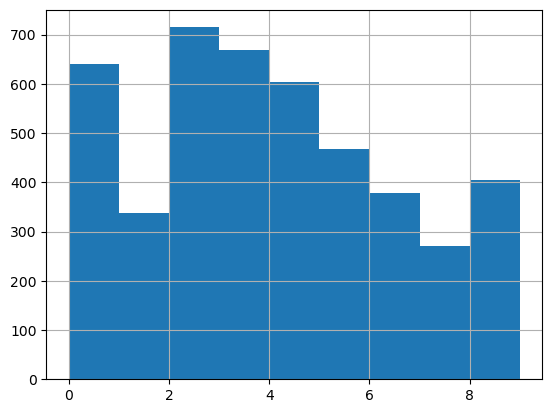

In [10]:
ny_blocks[ny_blocks["count"] < 10]["count"].hist(bins = list(range(0, 10)))

In [11]:
dataset_big = PatchesDataset(filenames=filenames, resize=(224, 224), resnet = True)
dl_big = torch.utils.data.DataLoader(dataset_big, batch_size=64)

In [27]:
dataset_test = SmallPatchesDataset(filenames = filenames)
dl_test = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=True)

tensor(0.1255) tensor(0.7804)


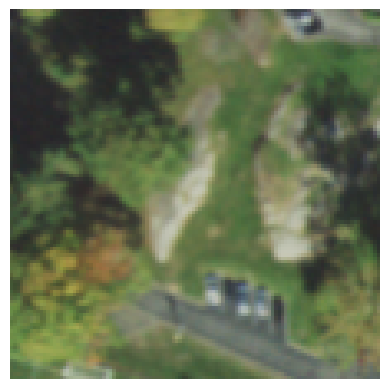

In [26]:
plot_sample(dataset_test[8][0])

tensor(0.4501) tensor(0.7023)


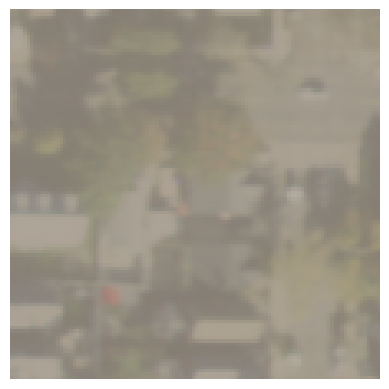

tensor(0.4369) tensor(0.7122)


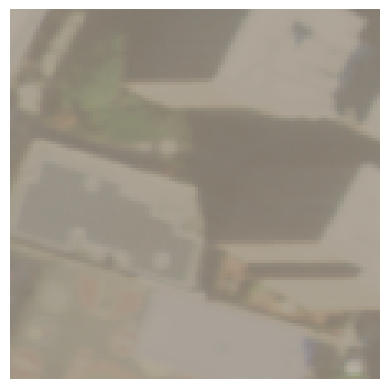

In [29]:
plot_sample(get_sample_from_batch(dl_test, 3), True)
plot_sample(get_sample_from_batch(dl_test, 2), True)

In [9]:
def get_sample_from_batch(batch, i = 0):
    j = 0
    for b, _ in batch:
        j += b.shape[0]
        if j > i:
            return b[i % b.shape[0]]
        
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def plot_sample(sample, resnet = False, ax = None):

    img = sample
    if resnet:
        img = inv_normalize(img)
    print(img.min(), img.max())
    img = img.permute(1, 2, 0).numpy()
    if ax is None:
        plt.imshow(img)
        plt.axis(False)
        plt.show()
    else:
        ax.imshow(img)

/home/giovani/anaconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


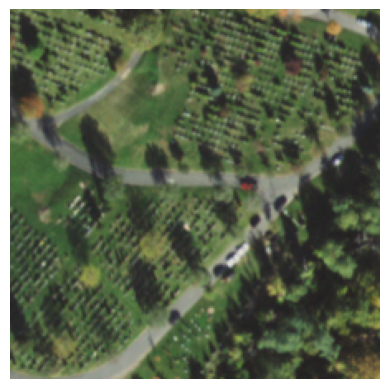

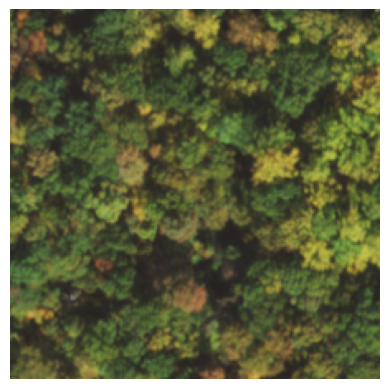

In [13]:
plot_sample(get_sample_from_batch(dl_big, 150), True)
plot_sample(get_sample_from_batch(dl_big, 200), True)

In [14]:
k = 20
latent_dim = 100

In [24]:
model_autoencoder = AutoEncoder(latent_dim, encoder_arch= "resnet50", decoder_layers_per_block = [3] * 5)
model_autoencoder.load_state_dict(torch.load(f"../models/AE_resnet50_v2/model.pt"))
model_autoencoder.eval()
model_autoencoder.to(device)
encoder = model_autoencoder.encoder
model = DEC(k, latent_dim, encoder)
model.load_state_dict(torch.load(f"../models/DEC_resnet50_clusters_{k}_v2/model.pt"))
model.eval()
model.to(device);

In [19]:
model.assignment.cluster_centers

torch.Size([20, 100])

In [43]:
out_sample[0].shape

torch.Size([1, 100])

tensor(0.1529) tensor(0.9176)


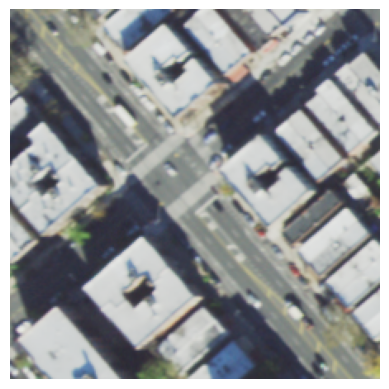

tensor(0.2199) tensor(0.8958)


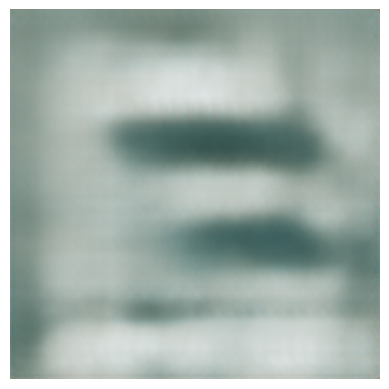

In [59]:
i = np.random.randint(0, len(dataset_big))
test_sample = dataset_big[i][0]
test_sample = test_sample.unsqueeze(0).to(device)
out_sample = model_autoencoder(test_sample)
plot_sample(test_sample[0].detach().cpu(), True)
plot_sample(out_sample[1][0].detach().cpu(), False)

In [27]:
cluster_centers_imgs = model_autoencoder.decoder(model.assignment.cluster_centers)

In [34]:
cluster_centers_imgs[1].detach().cpu().shape

torch.Size([3, 224, 224])

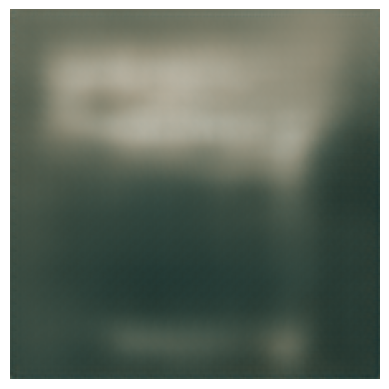

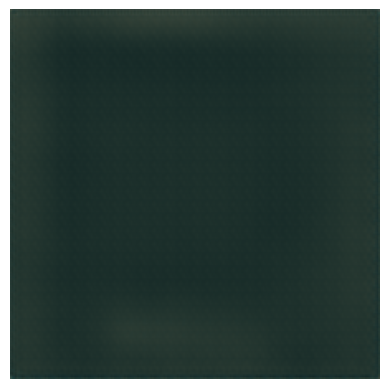

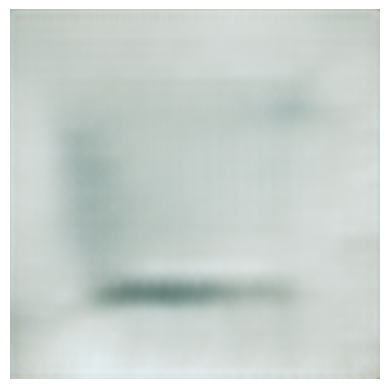

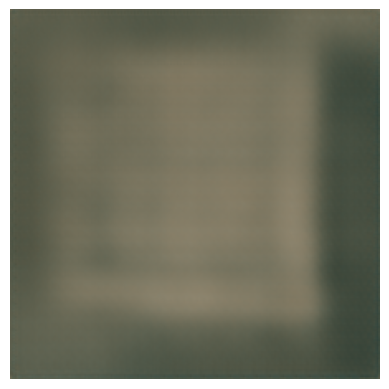

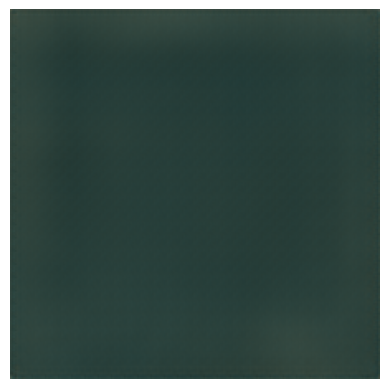

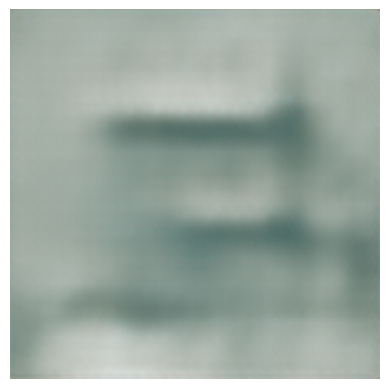

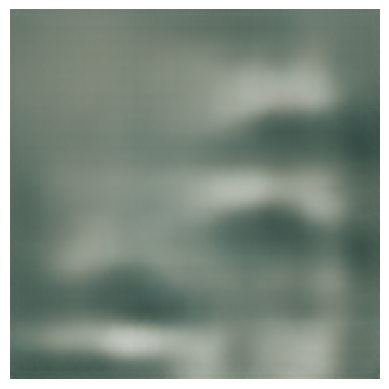

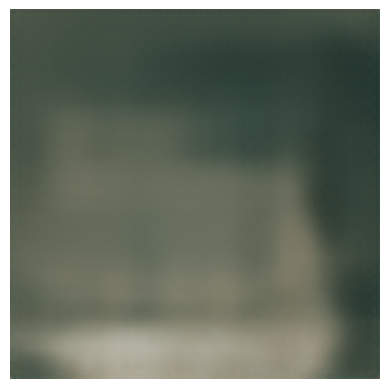

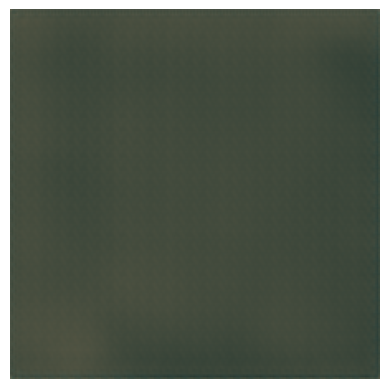

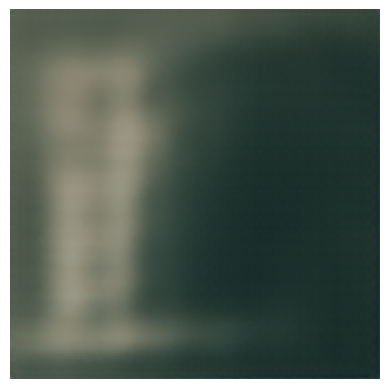

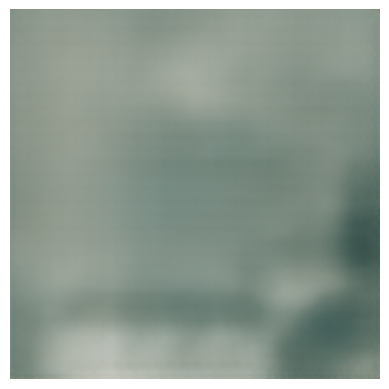

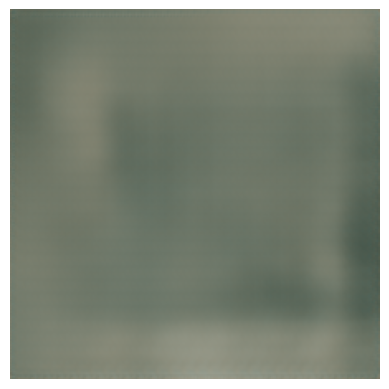

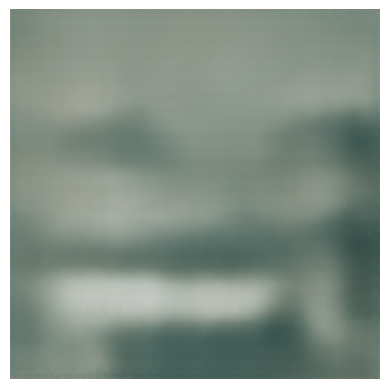

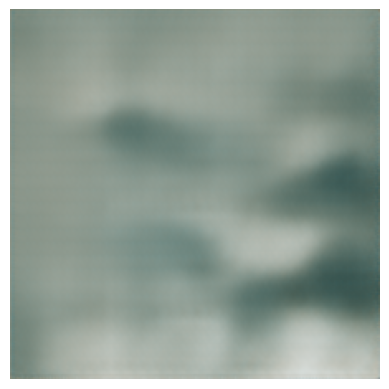

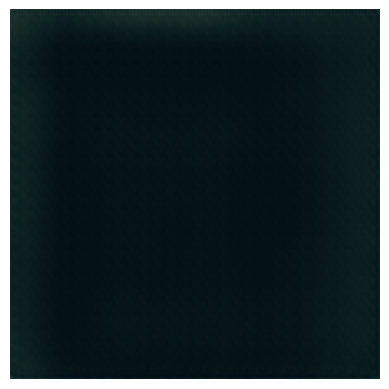

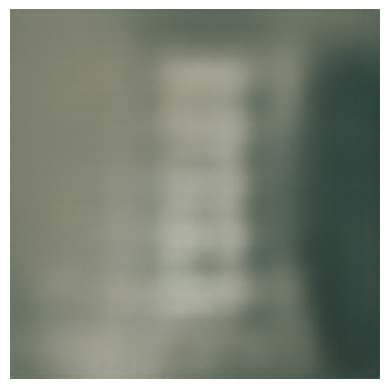

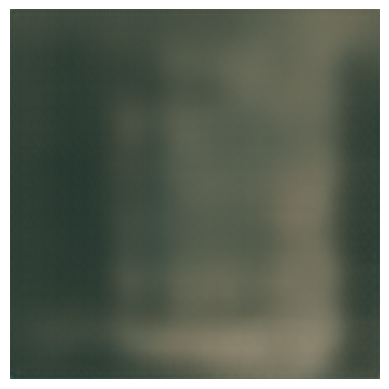

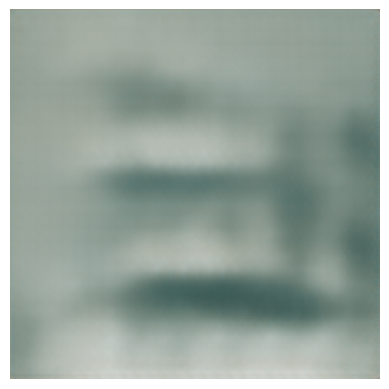

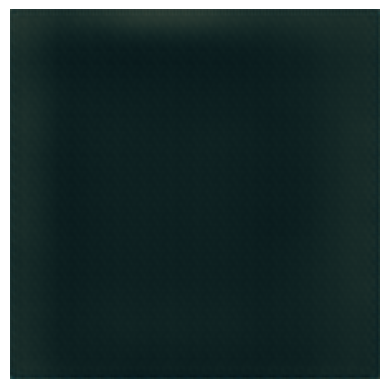

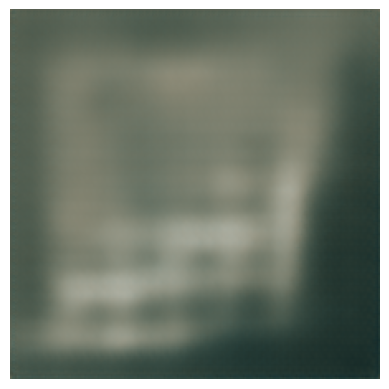

In [48]:
for i in range(20):
    plot_sample(cluster_centers_imgs[i].detach().cpu(), False)

In [34]:
cluster_distribution = []
for batch, _ in tqdm(dl_big):
    batch = batch.to(device)
    batch_size = batch.shape[0]
    z = model(batch).detach().cpu().numpy().reshape(batch_size, -1)
    cluster_distribution.append(z)
cluster_distribution = np.concatenate(cluster_distribution)

  0%|          | 0/631 [00:00<?, ?it/s]/home/giovani/anaconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 631/631 [03:37<00:00,  2.90it/s]


In [35]:
clusters = np.argmax(cluster_distribution, axis = 1)

(array([7.4400e+02, 0.0000e+00, 3.2540e+03, 1.0495e+04, 1.3898e+04,
        5.9600e+02, 0.0000e+00, 2.5540e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.6180e+03, 0.0000e+00, 5.1370e+03, 4.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.9000e+01, 3.9000e+01]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ,
        10.9, 11.8, 12.7, 13.6, 14.5, 15.4, 16.3, 17.2, 18.1, 19. ]),
 <BarContainer object of 20 artists>)

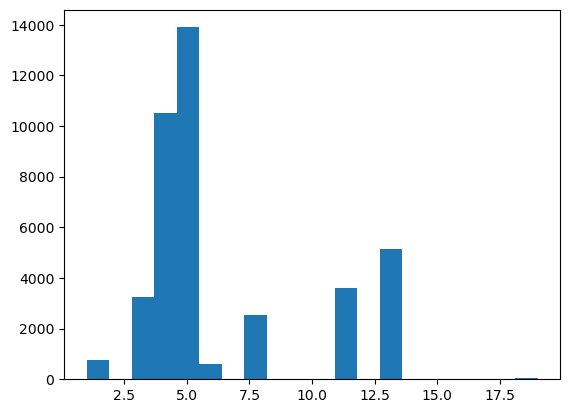

In [58]:
plt.hist(clusters, bins = k)

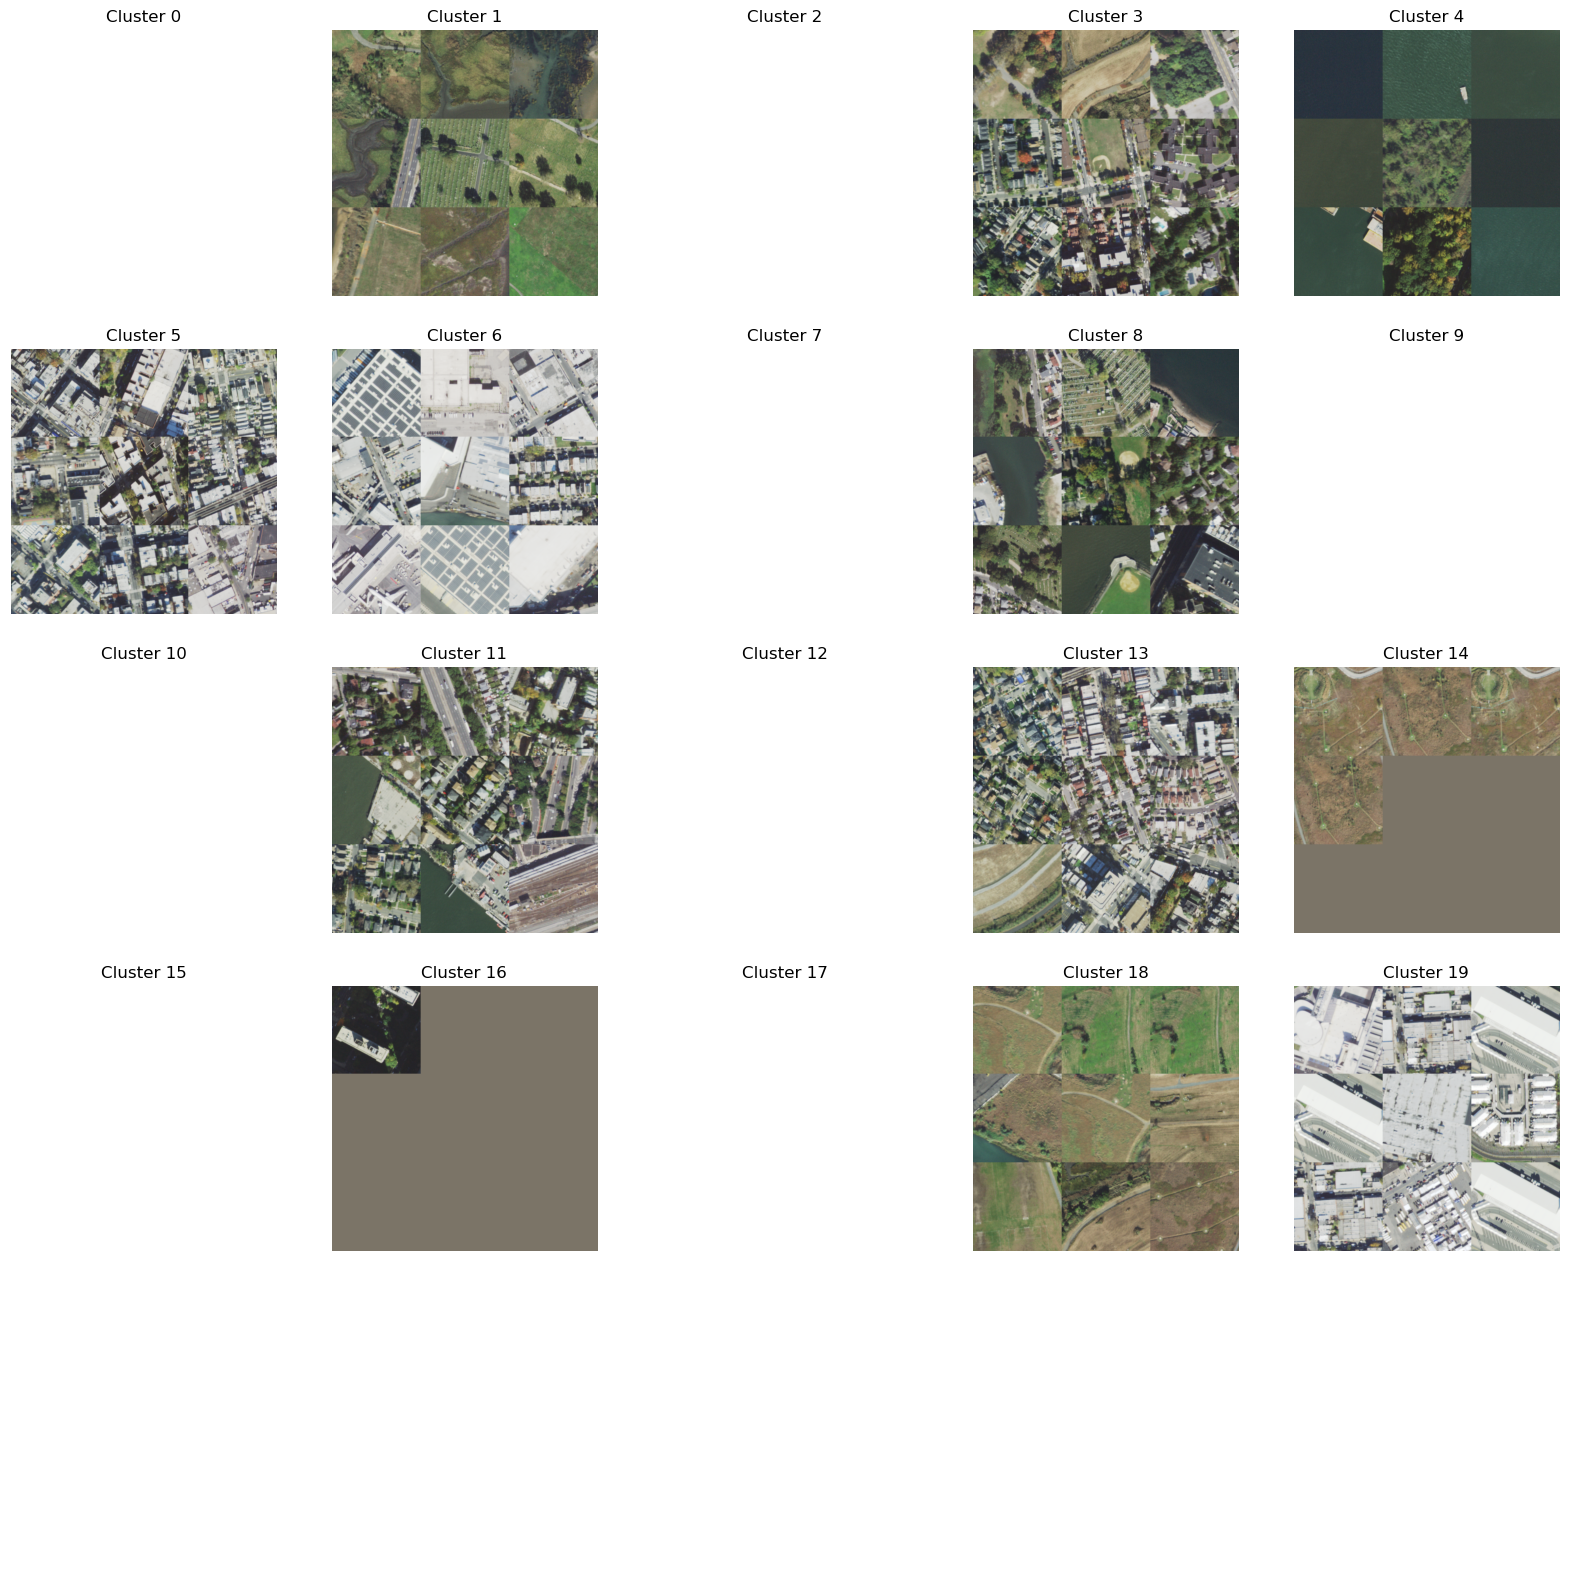

In [36]:
fig, axs = plt.subplots(ncols = 5, nrows = k // 5 + 1, figsize = (20, 4 * (k // 5 + 1)))
axs = axs.flatten()
[ax.axis(False) for ax in axs]
for i in range(k):
    samples = clusters == i
    axs[i].set_title(f"Cluster {i}")
    if samples.sum() == 0:
        continue

    random_sample = np.random.choice(np.where(samples)[0], min(9, samples.sum()))
    img = torch.zeros((3, 224 * 3, 224 * 3))
    for j, idx in enumerate(random_sample):
        img[:, (j // 3) * 224: (j // 3 + 1) * 224, (j % 3) * 224: (j % 3 + 1) * 224] = dataset_big[idx][0]
    plot_sample(img, True, axs[i])

In [37]:
# for each patch saves the cluster distribution
for i in range(cluster_distribution.shape[1]):
    patches_df[f"cluster_{i}"] = cluster_distribution[:, i]

In [38]:
patches_df_one_hot = patches_df.copy()
patches_df_one_hot = patches_df_one_hot.dropna()
patches_df_one_hot = patches_df_one_hot.drop(columns = ["geometry", "patche_filename", "entity_id", "patche_id"])
patches_df_one_hot = patches_df_one_hot.set_index(["block_id"])
# get the cluster with highest probability for each row
patches_df_one_hot = patches_df_one_hot.idxmax(axis = 1)
patches_df_one_hot = pd.get_dummies(patches_df_one_hot)
patches_df_one_hot = patches_df_one_hot.groupby("block_id").sum().reset_index()
patches_df_one_hot["mhi"] = patches_df_one_hot["block_id"].apply(lambda x: ny_blocks.loc[x].mhi)

In [49]:
# for each block sum the cluster distribution of the patches it contains
block_cluster_distribution = patches_df.drop(columns = ["patche_id"]).groupby("block_id").sum().reset_index()
 
# for each block normalize the cluster distribution
#block_cluster_distribution = block_cluster_distribution.div(block_cluster_distribution.sum(axis=1), axis=0).reset_index()
# get mhi value
block_cluster_distribution["mhi"] = block_cluster_distribution.block_id.astype(int).apply(lambda x : ny_blocks.loc[x].mhi)

/tmp/ipykernel_256835/3880304357.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  block_cluster_distribution = patches_df.drop(columns = ["patche_id"]).groupby("block_id").sum().reset_index()


In [51]:
x_train, x_test, y_train, y_test = train_test_split(patches_df_one_hot.iloc[:, 1:-1], patches_df_one_hot.mhi, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(block_cluster_distribution.iloc[:, 1:-1], block_cluster_distribution.mhi, test_size=0.2, random_state=42)

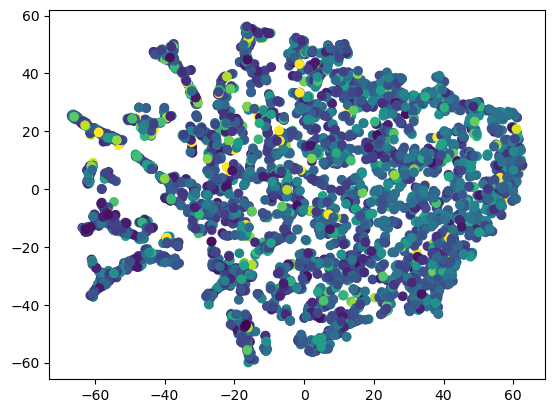

In [52]:
x_train_proj = TSNE(n_components=2).fit_transform(StandardScaler().fit_transform(x_train))

plt.scatter(x_train_proj[:, 0], x_train_proj[:, 1], c = y_train, cmap = "viridis")

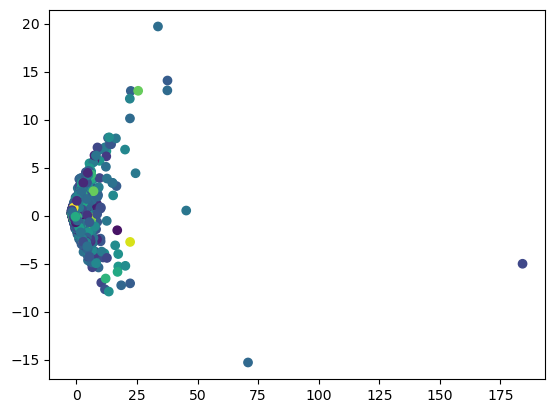

In [53]:
x_train_proj = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(x_train))

plt.scatter(x_train_proj[:, 0], x_train_proj[:, 1], c = y_train, cmap = "viridis")

In [54]:
svr = SVR()
parameters = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1, 10, 100],
    "gamma": [0.1, 1, 10, 100]
}
clf = GridSearchCV(svr, parameters)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Train")
print("MAE:", mean_absolute_error(y_train, clf.predict(x_train)))
print("R2:", r2_score(y_train, clf.predict(x_train)))
print("Test")
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

Train
MAE: 34258.23873660835
R2: -0.026097533164291198
Test
MAE:  33874.630968133766
R2:  -0.013725116566134066


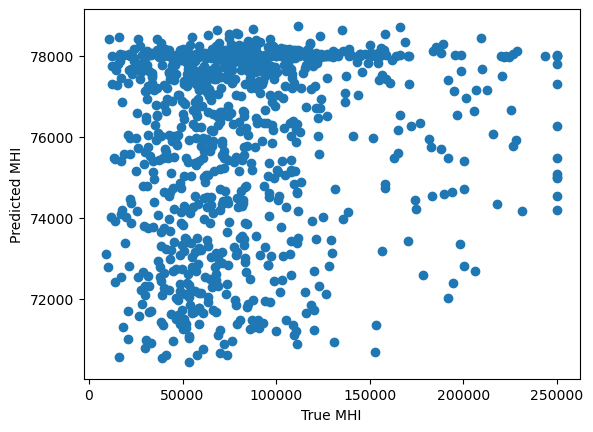

In [55]:
plt.plot(y_test, y_pred, "o")
plt.xlabel("True MHI")
plt.ylabel("Predicted MHI")
plt.show()

In [56]:
rf = RandomForestRegressor()
parameters = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [None, 10, 100],
    "min_samples_split": [2, 10, 100],
}
clf = GridSearchCV(rf, parameters)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Train")
print("MAE:", mean_absolute_error(y_train, clf.predict(x_train)))
print("R2:", r2_score(y_train, clf.predict(x_train)))
print("Test")
print("MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred)))
print("R2: ", r2_score(y_test, y_pred))

Train
MAE: 31803.156221207304
R2: 0.1934490928846201
Test
MAE:  185.09571438781472
R2:  0.05384533891096288


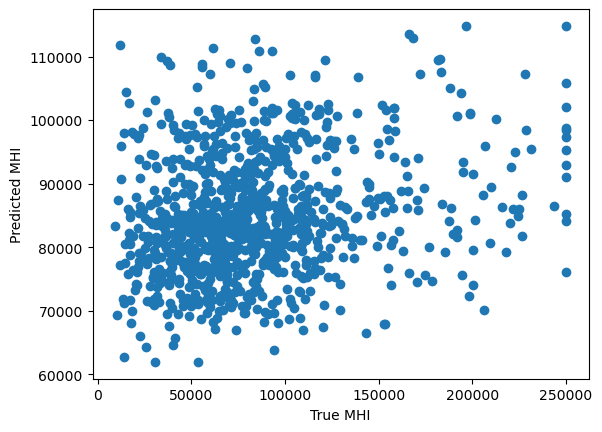

In [57]:
plt.plot(y_test, y_pred, "o")
plt.xlabel("True MHI")
plt.ylabel("Predicted MHI")
plt.show()